In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
import random
from sklearn import feature_selection
import statsmodels.formula.api as smf
from sklearn import metrics

Let's assume here is your actual output
y = [1,2,3,4,5]

And your prediction is

y_predict = [2,2,3,4,5]

Your MSE is ((1-2)^2 + (2-2)^2 + ... + (5-5)^2)/5 = 1/5 = .2

In [2]:
#Let's find MSE using sklearn 

y = [1,2,3,4,5]
y_predict = [2,2,3,4,5]
metrics.mean_squared_error(y,y_predict)

0.20000000000000001

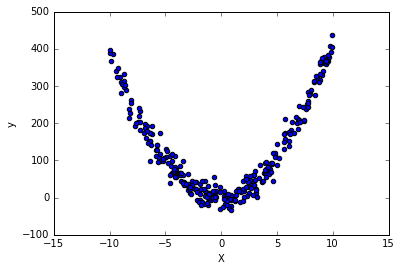

In [3]:
#Let's generate 300 random numbers between -10 and 10
x = np.zeros(300)
for i in range(300):
   x[i] = random.uniform(-10, 10)

#Let's generate some error term with mean 0 and s.d. = 20
error = np.random.normal(0,20,300)
#Now let's generate y with a polynomial degree 2 relationship with x

y = 3 + 1.5 * x + 4 * (x ** 2) + error
df = pd.DataFrame({'X': x, 'y': y})

df.plot(kind = 'scatter', x = 'X', y = 'y')

In [4]:
#Now let's add few non-linear terms to our data frame
df['X_2'] = df.X ** 2
df['X_3'] = df.X ** 3
df['X_4'] = df.X ** 4
df['X_5'] = df.X ** 5

df.head(2)

,X,y,X_2,X_3,X_4,X_5
0,3.812006,67.420625,14.531392,55.393759,211.161360,804.948442
1,7.781027,260.698106,60.544375,471.097398,3665.621396,28522.297704


In [7]:
X1 = df[['X']]
X2 = df[['X','X_2']]
X3 = df[['X','X_2','X_3']]
X4 = df[['X','X_2','X_3','X_4']]
X5 = df[['X','X_2','X_3','X_4','X_5']]
X6 = df[['X','X_2','X_4']]
y = df['y']

In [8]:
lm = linear_model.LinearRegression()
MSE = np.zeros(6)
j = 0
for i in [X1,X2,X3,X4,X5,X6]:
    lm.fit(i,y)
    MSE[j] = (metrics.mean_squared_error(lm.predict(i),y))
    pvals = feature_selection.f_regression(i,y)[1]
    print(pvals)
    j += 1



[ 0.00031782]
[  3.17819261e-004   2.06784246e-227]
[  3.17819261e-004   2.06784246e-227   1.78929925e-005]
[  3.17819261e-004   2.06784246e-227   1.78929925e-005   1.70008189e-143]
[  3.17819261e-004   2.06784246e-227   1.78929925e-005   1.70008189e-143
   1.09102289e-005]
[  3.17819261e-004   2.06784246e-227   1.70008189e-143]


#### in comparison to R, sklearn is using a different method to estimate p-values. P-values in sklearn are not reliable. If you want to use p-values, use statsmodels.formula.api

In [41]:
for i in [X1,X2,X3,X4,X5]:
    lm1 = smf.ols(formula='y ~ i', data=df).fit()
    #print(lm1.summary())
    print(lm1.pvalues)


Intercept    7.843784e-48
i            3.178193e-04
dtype: float64
Intercept     4.831682e-02
i[0]          1.027342e-10
i[1]         6.262702e-233
dtype: float64
Intercept     4.594555e-02
i[0]          4.946699e-02
i[1]         3.989930e-231
i[2]          3.036965e-01
dtype: float64
Intercept    5.463564e-01
i[0]         5.563853e-02
i[1]         1.445583e-93
i[2]         2.409054e-01
i[3]         9.278757e-02
dtype: float64
Intercept    5.430314e-01
i[0]         5.917960e-01
i[1]         1.024689e-93
i[2]         1.983811e-02
i[3]         1.164417e-01
i[4]         3.407819e-02
dtype: float64


#### Based on P-values, it is clear that our models are only valid up to 2 degrees of polynomial. After that coefficients are not statistically significant. 

# Validation

As much as sklearn performs weak for p-values, it is a great tool for splitting data into Training and Test set. 

In [10]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33)
#We train based on Training Data BUT will Test on Test Sample
Model_train = lm.fit(X_train,y_train)
y_Hat_train = lm.predict(X_train)
y_Hat_test  = lm.predict(X_test)
MSE_Train = metrics.mean_squared_error(y_Hat_train,y_train)
MSE_Test  = metrics.mean_squared_error(y_Hat_test,y_test)
print("MSE_Train =",MSE_Train)
print("MSE_Test =", MSE_Test)
#print(y_Hat_train)

('MSE_Train =', 13268.613593925736)
('MSE_Test =', 15858.672169415275)


Now, it's time to use Validation techniques to test which model is more significant. Remember we need to train based on training sets but test the performance on test set.

[ 4.91164484]
[ 1.60721715  3.98367153]
[ 0.92098803  3.99600154  0.00960025]
[  6.61702211e-01   4.35411050e+00   1.22781808e-02  -3.42410331e-03]
[ -2.44587386e-01   4.21617572e+00   6.37735810e-02  -2.09387407e-03
  -4.98048850e-04]


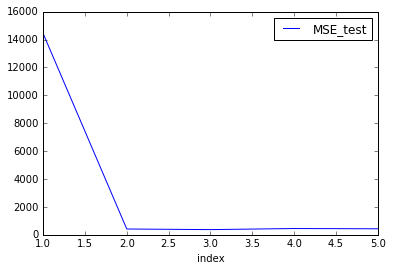

In [11]:
MSE_test = np.zeros(5)
MSE_train = np.zeros(5)
j = 0
for i in [X1,X2,X3,X4,X5]:
    X_train, X_test, y_train, y_test = train_test_split(i, y, test_size=0.33)
    lm.fit(X_train,y_train)
    MSE_test[j] = (metrics.mean_squared_error(lm.predict(X_test),y_test))
    MSE_train[j] = (metrics.mean_squared_error(lm.predict(X_train),y_train))
    print lm.coef_
    j += 1

index = np.array(range(5)) + 1
MSE_Test_df = pd.DataFrame({'MSE_test':MSE_test,'index':index})
MSE_Test_df.plot(x = 'index',y= 'MSE_test')


Based on test-set MSE, we decide to choose Model 2 - polynomial degree 2. Remember ** THE SIMPLER THE BETTER **.

# Cross-Validation

sklearn is great for Cross-Validation. 10 fold and 5 fold cross-validation are the most famous cross-validation techniques. 

In [12]:
from sklearn import cross_validation
kf = cross_validation.KFold(len(df), n_folds = 5, shuffle = True)

for i in [X1, X2, X3, X4]:
    scores = []
    for train_index, test_index in kf:
        lm = linear_model.LinearRegression().fit(i.iloc[train_index], y.iloc[train_index])
        scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(i.iloc[test_index])))
    print(scores)
    print(np.mean(scores))


    
  

[18678.991396905552, 11045.589387437078, 15169.940296910161, 13238.42508360512, 12649.65781350643]
14156.5207957
[453.06620166944435, 414.10289079803317, 386.64988260728404, 404.31900118283306, 341.95766415065543]
400.019128082
[450.07693461504726, 416.16215720646971, 383.59047820002559, 401.95572095112897, 343.04148162230751]
398.965354519
[451.74739145432534, 420.2094134002885, 375.74238454224928, 406.60093398723694, 333.58791886231182]
397.577608449


#### Now, let's use cross validation to decide which degree of polynomials is suitable for our simulated model. 

[14550.60085096625, 400.10291517716735, 404.58355539336753, 405.40404907329446, 402.39576913167923]


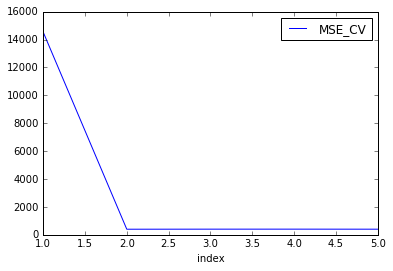

In [13]:
kf = cross_validation.KFold(len(df), n_folds = 5, shuffle = True)
MSE_CV = []

for i in [X1,X2,X3,X4,X5]:
    scores = []
    for train_index, test_index in kf:
        lm = linear_model.LinearRegression().fit(i.iloc[train_index], y.iloc[train_index])
        scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(i.iloc[test_index])))
    MSE_CV.append(np.mean(scores))
        
        
print(MSE_CV)
index = np.array(range(5)) + 1
MSE_CV_df = pd.DataFrame({'MSE_CV':MSE_CV,'index':index})
MSE_CV_df.plot(x = 'index',y= 'MSE_CV')

Again, 5-fold cross-validation suggests that polynomial degree 2 is our best model. 

# Lasso and Ridge Regression

We are going to use Credit data. We will first add dummy variables and drop original qualitative values. 

In [15]:
url = "https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/Credit.csv"
CreditData = pd.read_csv(url)
RaceDummy = pd.get_dummies(CreditData.Ethnicity, prefix = 'Race')
del RaceDummy['Race_African American']
GenderDummy = pd.get_dummies(CreditData.Gender, prefix = 'Gender')
del GenderDummy['Gender_ Male']  
MarriedDummy = pd.get_dummies(CreditData.Married, prefix = 'Married')
del MarriedDummy['Married_No']
StudentDummy = pd.get_dummies(CreditData.Student, prefix = 'Student')
del StudentDummy['Student_No']
CreditData = pd.concat([CreditData, RaceDummy,GenderDummy,MarriedDummy,StudentDummy], axis=1)



del CreditData['Unnamed: 0']
del CreditData['Gender']
del CreditData['Student']
del CreditData['Married']
del CreditData['Ethnicity']
CreditData.head(2)
CreditData.corr()

,Income,Limit,Rating,Cards,Age,Education,Balance,Race_Asian,Race_Caucasian,Gender_Female,Married_Yes,Student_Yes
Income,1.000000,0.792088,0.791378,-0.018273,0.175338,-0.027692,0.463656,-0.017137,-0.019701,-0.010738,0.035652,0.019632
Limit,0.792088,1.000000,0.996880,0.010231,0.100888,-0.023549,0.861697,-0.032427,-0.003081,0.009397,0.031155,-0.006015
Rating,0.791378,0.996880,1.000000,0.053239,0.103165,-0.030136,0.863625,-0.035999,-0.001070,0.008885,0.036751,-0.002028
Cards,-0.018273,0.010231,0.053239,1.000000,0.042948,-0.051084,0.086456,0.005591,-0.005631,-0.022658,-0.009695,-0.026164
Age,0.175338,0.100888,0.103165,0.042948,1.000000,0.003619,0.001835,-0.059623,-0.000822,0.004015,-0.073136,-0.029844
Education,-0.027692,-0.023549,-0.030136,-0.051084,0.003619,1.000000,-0.008062,0.029586,-0.037725,-0.005049,0.048911,0.072085
Balance,0.463656,0.861697,0.863625,0.086456,0.001835,-0.008062,1.000000,-0.009812,-0.003288,0.021474,-0.005673,0.259018
Race_Asian,-0.017137,-0.032427,-0.035999,0.005591,-0.059623,0.029586,-0.009812,1.000000,-0.582131,0.025425,0.088595,0.053534
Race_Caucasian,-0.019701,-0.003081,-0.001070,-0.005631,-0.000822,-0.037725,-0.003288,-0.582131,1.000000,-0.009831,0.011418,-0.048334
Gender_Female,-0.010738,0.009397,0.008885,-0.022658,0.004015,-0.005049,0.021474,0.025425,-0.009831,1.000000,0.012452,0.055034


Now we are going to divide our dataset - to output y and all inputs X.

In [16]:
listOfAllVariables = CreditData.columns.values
print(listOfAllVariables)
X = CreditData[listOfAllVariables]
del X['Balance']
y = CreditData['Balance']


['Income' 'Limit' 'Rating' 'Cards' 'Age' 'Education' 'Balance' 'Race_Asian'
 'Race_Caucasian' 'Gender_Female' 'Married_Yes' 'Student_Yes']


In [17]:
#this was a lasso regression with default values
lm_lasso = linear_model.Lasso().fit(X,y)
lm_lasso.coef_

/Users/jcano/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


array([ -7.79768835e+00,   1.89911017e-01,   1.14879401e+00,
         1.71481939e+01,  -6.23887605e-01,  -9.72072517e-01,
         4.56163923e+00,   0.00000000e+00,  -6.18488629e+00,
        -3.90309045e+00,   4.14716815e+02])

We need to use CV to decide on the optimal level of Alpha - the parameter of Lasso Regressions. 

Alpha: 1e-10
Alpha: 1e-09
Alpha: 1e-08
Alpha: 1e-07
Alpha: 1e-06
Alpha: 1e-05
Alpha: 0.0001
Alpha: 0.001
Alpha: 0.01
Alpha: 0.1
Alpha: 1.0
Alpha: 10.0
Alpha: 100.0
Alpha: 1000.0
Alpha: 10000.0
Alpha: 100000.0
Alpha: 1000000.0
Alpha: 10000000.0
Alpha: 100000000.0
Alpha: 1000000000.0
Alpha: 10000000000.0


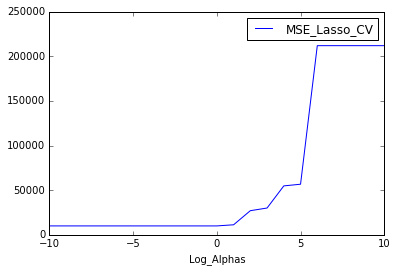

In [18]:
kf = cross_validation.KFold(len(CreditData), n_folds = 5, shuffle = True)
MSE_Lasso_CV = []
alphas = np.logspace(-10, 10, 21)
alphas_index = np.linspace(-10,10,21)
scores = []
for a in alphas:
    print 'Alpha:', a
    scores = []
    for train_index, test_index in kf:
        lm = linear_model.Lasso(alpha=a).fit(X.iloc[train_index], y.iloc[train_index])
        scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    MSE_Lasso_CV.append(np.mean(scores))

index = alphas
MSE_Lasso_CV_df = pd.DataFrame({'MSE_Lasso_CV': MSE_Lasso_CV ,'Log_Alphas': alphas_index })
MSE_Lasso_CV_df.plot(x = 'Log_Alphas',y = 'MSE_Lasso_CV')

In [19]:
#MSE is flat up to log_alpha = 1. Log_alpha results in alpha = 10 (due to its logarithmic scale)
lm = linear_model.Lasso(alpha=10)
lm.fit(X, y)
print zip(lm.coef_,X.columns)


[(-7.7452702188442073, 'Income'), (0.1527915981524203, 'Limit'), (1.6939844409415519, 'Rating'), (9.3463465619643706, 'Cards'), (-0.64262417332434862, 'Age'), (-0.0, 'Education'), (0.0, 'Race_Asian'), (-0.0, 'Race_Caucasian'), (-0.0, 'Gender_Female'), (-0.0, 'Married_Yes'), (312.03242606548304, 'Student_Yes')]


#### Based on Lasso regression outputs, we decide to eliminate Gender, Marital Status, Education, and Race from our model. The coefficients that made it to our final models were Income, Limit, Rating (we shall only choose 1 of these three variables due to colinearity), Number of Cards, Age, and Studentship. Based on our previous In-Class-Practice, we were expecting to have Income and Studentship in our model. Now, since we are only left with 4 variables, we can run statistical tests and choose the most significant model. 


#### Ridge Regression

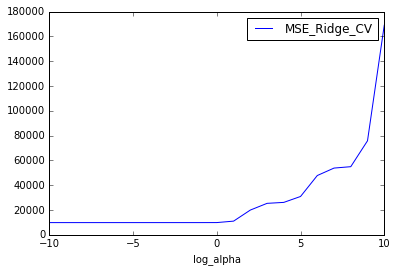

In [20]:
kf = cross_validation.KFold(len(CreditData), n_folds = 5, shuffle = True)
MSE_Ridge_CV = []
alphas = np.logspace(-10, 10, 21)
alphas_index = np.linspace(-10,10,21)
scores = []
for a in alphas:
    #print 'Alpha:', a
    scores = []
    for train_index, test_index in kf:
        lm = linear_model.Ridge(alpha=a).fit(X.iloc[train_index], y.iloc[train_index])
        scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    MSE_Ridge_CV.append(np.mean(scores))

            #print lm.coef_
        #MSE_Lasso_CV.append(metrics.mean_squared_error(y, lm.predict(X)))

index = alphas
MSE_Ridge_CV_df = pd.DataFrame({'MSE_Ridge_CV': MSE_Ridge_CV ,'log_alpha': alphas_index })
MSE_Ridge_CV_df.plot(x = 'log_alpha',y = 'MSE_Ridge_CV')

In [21]:
#MSE is flat up to log_Alpha = 1. log_alpha = 1 results in alpha = 10 (due to its logarithmic scale)
lm = linear_model.Ridge(alpha=10)
lm.fit(X, y)
print zip(lm.coef_,X.columns)


[(-7.747799013419014, 'Income'), (0.17285121974513507, 'Limit'), (1.3970960824616014, 'Rating'), (15.876236498180402, 'Cards'), (-0.68449356198776856, 'Age'), (-0.37478071530889612, 'Education'), (16.057222603221042, 'Race_Asian'), (6.4662844414632579, 'Race_Caucasian'), (-6.7895204897805215, 'Gender_Female'), (-12.616631546033105, 'Married_Yes'), (331.10065419030207, 'Student_Yes')]


#### Based on Ridge regression model, we are not comfortable to eliminate any variable. Generally, Lasso is much better than Ridge Regression.  

# Scaling / Standardizing Data

In [22]:
from sklearn import preprocessing

In [23]:
CreditDataNew = preprocessing.scale(CreditData) #CreditDataNew is now a numpy array
CreditDataNew = pd.DataFrame(CreditDataNew)   #We changed CreditDataNew to a dataframe
CreditDataNew.columns = CreditData.columns.values  #We renamed columns of CreditDataNew

In [24]:
CreditDataNew.head()

,Income,Limit,Rating,Cards,Age,Education,Balance,Race_Asian,Race_Caucasian,Gender_Female,Married_Yes,Student_Yes
0,-0.861583,-0.489999,-0.465539,-0.699130,-1.257674,-0.784930,-0.407277,-0.585049,1.005013,-1.035635,0.795395,-0.333333
1,1.727437,0.828261,0.828703,0.031032,1.528451,0.496588,0.834056,1.709260,-0.995012,0.965592,0.795395,3.000000
2,1.686756,1.014787,1.029311,0.761194,0.889964,-0.784930,0.130634,1.709260,-0.995012,-1.035635,-1.257237,-0.333333
3,2.946152,2.068440,2.110003,0.031032,-1.141586,-0.784930,0.966900,1.709260,-0.995012,0.965592,-1.257237,-0.333333
4,0.302928,0.070012,0.013331,-0.699130,0.715831,0.816968,-0.411633,-0.585049,1.005013,-1.035635,0.795395,-0.333333


In [25]:
X = CreditDataNew[listOfAllVariables]
del X['Balance']
y = CreditDataNew['Balance']

Alpha: 1e-10
0.048549814373
Alpha: 1e-09
0.0485498143394
Alpha: 1e-08
0.0485498140035
Alpha: 1e-07
0.0485498106446
Alpha: 1e-06
0.0485497770766
Alpha: 1e-05
0.0485528712906
Alpha: 0.0001
0.0485568058473
Alpha: 0.001
0.0485116355313
Alpha: 0.01
0.0492273222388
Alpha: 0.1
0.166568243905
Alpha: 1.0
1.00177675645
Alpha: 10.0
1.00177675645
Alpha: 100.0
1.00177675645
Alpha: 1000.0
1.00177675645
Alpha: 10000.0
1.00177675645
Alpha: 100000.0
1.00177675645
Alpha: 1000000.0
1.00177675645
Alpha: 10000000.0
1.00177675645
Alpha: 100000000.0
1.00177675645
Alpha: 1000000000.0
1.00177675645
Alpha: 10000000000.0
1.00177675645


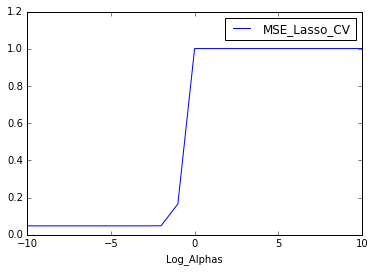

In [26]:
kf = cross_validation.KFold(len(CreditDataNew), n_folds = 5, shuffle = True)
MSE_Lasso_CV = []
alphas = np.logspace(-10, 10, 21)
alphas_index = np.linspace(-10,10,21)
scores = []
for a in alphas:
    print 'Alpha:', a
    scores = []
    for train_index, test_index in kf:
        lm = linear_model.Lasso(alpha=a).fit(X.iloc[train_index], y.iloc[train_index])
        scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    MSE_Lasso_CV.append(np.mean(scores))
    print(np.mean(scores))



index = alphas
MSE_Lasso_CV_df = pd.DataFrame({'MSE_Lasso_CV': MSE_Lasso_CV ,'Log_Alphas': alphas_index })
MSE_Lasso_CV_df.plot(x = 'Log_Alphas',y = 'MSE_Lasso_CV')

In [27]:
lm = linear_model.Lasso(alpha=10**(-2))
lm.fit(X, y)
print zip(lm.coef_,X.columns)

[(-0.55167106880804095, 'Income'), (0.87350643006043971, 'Limit'), (0.41941036771521767, 'Rating'), (0.042801835650123063, 'Cards'), (-0.016712885686218062, 'Age'), (-0.0, 'Education'), (0.0, 'Race_Asian'), (0.0, 'Race_Caucasian'), (-1.7624789549735009e-05, 'Gender_Female'), (-0.0, 'Married_Yes'), (0.26657472496548718, 'Student_Yes')]


#### When you standardize data, then relative magnitude of coefficients are meaningful. Small Coefficients suggest insignificancy of inclusion of that variable in your model. In this case, Income, Limit, Rating and Student_status are considerably more significant than other variables. Among (Income, Limit and Rating) we only choose one due to high colinearity. Therefore, in are final model it is logical to keep (income, Limit, or Rating) + Student stauts. 

In [28]:
CreditDataNew.corr()

,Income,Limit,Rating,Cards,Age,Education,Balance,Race_Asian,Race_Caucasian,Gender_Female,Married_Yes,Student_Yes
Income,1.000000,0.792088,0.791378,-0.018273,0.175338,-0.027692,0.463656,-0.017137,-0.019701,-0.010738,0.035652,0.019632
Limit,0.792088,1.000000,0.996880,0.010231,0.100888,-0.023549,0.861697,-0.032427,-0.003081,0.009397,0.031155,-0.006015
Rating,0.791378,0.996880,1.000000,0.053239,0.103165,-0.030136,0.863625,-0.035999,-0.001070,0.008885,0.036751,-0.002028
Cards,-0.018273,0.010231,0.053239,1.000000,0.042948,-0.051084,0.086456,0.005591,-0.005631,-0.022658,-0.009695,-0.026164
Age,0.175338,0.100888,0.103165,0.042948,1.000000,0.003619,0.001835,-0.059623,-0.000822,0.004015,-0.073136,-0.029844
Education,-0.027692,-0.023549,-0.030136,-0.051084,0.003619,1.000000,-0.008062,0.029586,-0.037725,-0.005049,0.048911,0.072085
Balance,0.463656,0.861697,0.863625,0.086456,0.001835,-0.008062,1.000000,-0.009812,-0.003288,0.021474,-0.005673,0.259018
Race_Asian,-0.017137,-0.032427,-0.035999,0.005591,-0.059623,0.029586,-0.009812,1.000000,-0.582131,0.025425,0.088595,0.053534
Race_Caucasian,-0.019701,-0.003081,-0.001070,-0.005631,-0.000822,-0.037725,-0.003288,-0.582131,1.000000,-0.009831,0.011418,-0.048334
Gender_Female,-0.010738,0.009397,0.008885,-0.022658,0.004015,-0.005049,0.021474,0.025425,-0.009831,1.000000,0.012452,0.055034


In [37]:
kf = cross_validation.KFold(len(CreditDataNew), n_folds = 5, shuffle = True)
scores = []
X = CreditDataNew[["Rating", "Student_Yes"]]
for test_index, train_index in kf:
    lm = linear_model.LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
print scores
print(lm.coef_)

[0.21084294953537533, 0.21228299272641885, 0.19759995619745496, 0.21989677493794879, 0.19027561650164193]
[ 0.82910322  0.25303007]
